In [1]:
from expl_bind_vertex_calc import *
import time
import matplotlib.pyplot as plt
import matplotlib.patches
import seaborn as sns
import scipy as sp
from matplotlib.colors import LogNorm
import matplotlib as mpl

In [70]:
# Eigvect restircted minimization

n_bind = 2 #types of proteins/marks
e_m = np.array([1.52, 1.52]) #binding energy FOR F_BIND_ALT
v_int =  np.array([[-4, 4], [4, -4]])
phi_p = 0.7
phi_A = 0.1
phi_B = 0.1
M = 50
nm = M
pa_vec = np.arange(0, nm, 1) / (nm-1)
pb_vec = 1-pa_vec
poly_marks = [pa_vec, pb_vec]

# test
mu_max_1 = -2-1.5#8#0.1 #10
mu_min_1 = -4-1.5#-9
# mu_min_1 = -8-1.5#-9
del_mu_1 = 0.5#.5 #0.25
mu_max_2 = mu_max_1
mu_min_2 = mu_min_1
del_mu_2 = del_mu_1

mu1_arr = np.arange(mu_min_1, mu_max_1, del_mu_1)
mu2_arr = np.arange(mu_min_2, mu_max_2, del_mu_2)

v_s = 1
v_p = 1
v_A = v_p
v_B = v_p
N_P = 5000
N_A = 50
N_B = N_A
b_P = 1
b_A = b_P
b_B = b_P

psol = Polymer_soln(n_bind, v_int, e_m, phi_p, phi_A, phi_B, \
                    poly_marks, mu1_arr, mu2_arr, v_s, v_p, v_A, v_B, N_P, N_A, N_B,
                    b_P, b_A, b_B)


klog_min = -2.5
klog_max = -.1
klog_num = 30
k_vec = np.logspace(klog_min, klog_max, klog_num) / b_P

In [72]:
%%time
s_bind_A_ALL, s_bind_B_ALL = calc_binding_states(psol)

CPU times: total: 1.17 s
Wall time: 1.18 s


In [74]:
mu1_arr

array([-5.5, -5. , -4.5, -4. ])

Text(0, 0.5, '$\\langle s \\rangle$')

<Figure size 640x480 with 0 Axes>

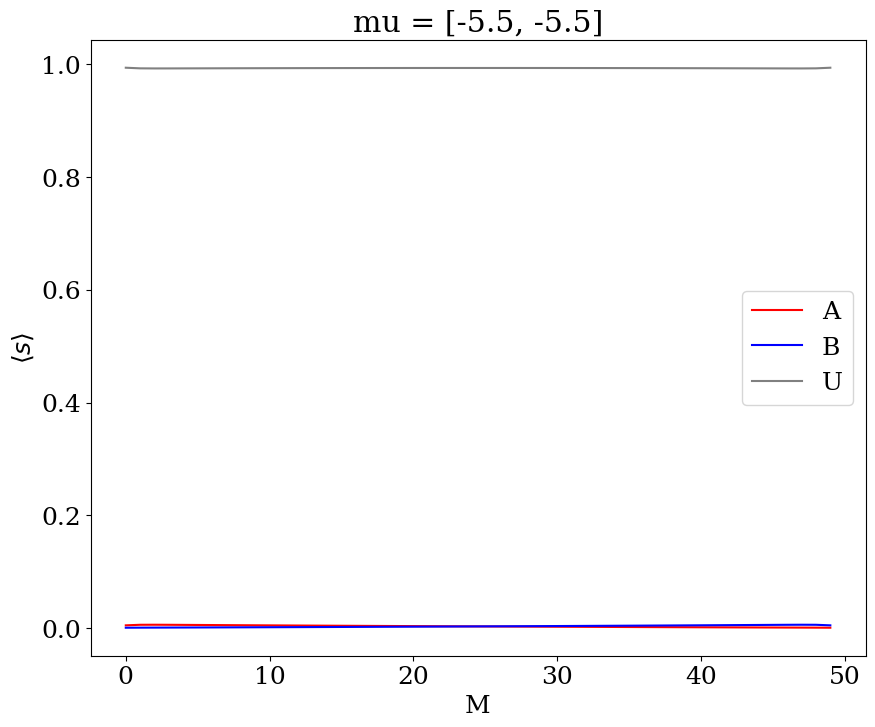

In [76]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

mu1 = -5.5#np.round(-3.8-1.5, 1)
mu2 = -5.5#.2-1.5

mu1_ind = np.where(mu1_arr == mu1)[0][0]
mu2_ind = np.where(mu2_arr == mu2)[0][0]

s_bnd_A = s_bind_A_ALL[mu1_ind,mu2_ind,:]
s_bnd_B = s_bind_B_ALL[mu1_ind,mu2_ind,:]
s_unbnd = 1 - (s_bnd_A+s_bnd_B)

plt.plot(np.arange(len(s_bnd_A)), s_bnd_A, color = "red", label = "A")
plt.plot(np.arange(len(s_bnd_A)), s_bnd_B, color = "blue", label = "B")
plt.plot(np.arange(len(s_bnd_A)), s_unbnd, color = "grey", label = "U")
plt.legend()
plt.title(r"mu = [%s, %s]" % (mu1, mu2))
plt.xlabel("M")
plt.ylabel(r"$\langle s \rangle$")

In [86]:
# %%time
# k* stability analysis NUMBER DENSITY THEORY
# chi = 0#5*N/N

chi_AP = 0
chi_BP = 0
chi_AB = 0 / (phi_p*N_P) #(v_int[0,1] - 0.5*(v_int[0,0] + v_int[1,1]))*Vol_int/100
chi_PS = 0
chi_AS = 0
chi_BS = 0

chis = [chi_AP, chi_BP, chi_AB, chi_PS, chi_AS, chi_BS]


min_eigval_arr = np.zeros((len(mu1_arr[:]), len(mu2_arr[:]), len(k_vec)))

min_eigval_arr_allk_DENS = np.zeros((len(mu1_arr[:]), len(mu2_arr[:])))
min_eigval_arr_allk_ps = np.zeros((len(mu1_arr[:]), len(mu2_arr[:])))

min_eigvec_arr = np.zeros((len(mu1_arr[:]), len(mu2_arr[:]), len(k_vec), 5))
min_eigvec_arr_allk_DENS = np.zeros((len(mu1_arr[:]), len(mu2_arr[:]), 5))

k_star_arr_DENS= np.zeros((len(mu1_arr[:]), len(mu2_arr[:]))) 

cond_num_arr = np.zeros((len(mu1_arr[:]), len(mu2_arr[:]), len(k_vec)))
max_cond_arr = np.zeros((len(mu1_arr[:]), len(mu2_arr[:])))

for i, mu1 in enumerate(mu1_arr):
    for j, mu2 in enumerate(mu2_arr):
#         if mu1 == mu2:
#             continue
        mu = [mu1, mu2]
        # print("mu: ", mu)

        for ik, k in enumerate(k_vec):

            # print(k)

            s_bnd_A = s_bind_A_ALL[i, j]
            s_bnd_B = s_bind_B_ALL[i, j]

            # M2s = calc_mon_mat_2(s_bnd_A, s_bnd_B, competitive)
            # S2_mat = (phi_p / N) * calc_sf2(psol, M2s, [k], competitive)
            # cond_num_arr[i][j][ik] = np.linalg.cond(S2_mat)

            G2 = gamma2_chis(psol, s_bnd_A, s_bnd_B, k, chis)

            
            # s_bnd_A = s_bind_A_ar[i, j]
            # s_bnd_B = s_bind_B_ar[i, j]

            # G2 = gamma2(chrom, s_bnd_A, s_bnd_B, k, chi, competitive)

            
            val, vec = np.linalg.eigh(G2)
            print(val)
            vec = vec.T
#                 print(vec)
#                 print(vec.T)
#                 print(val)
            min_val = np.min(val)            
            min_eigval_arr[i][j][ik] = min_val
            min_eigvec_arr[i][j][ik] = vec[np.where(val == min_val)]


        # all-k analysis
        # min eigvals, eigvecs at given mu1,mu2 for each k        
        min_vals = min_eigval_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])] 
        min_vecs = min_eigvec_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])]

        # minimum eigenvalue at given mu1,mu2 across all ks
        minval_allk = np.min(min_vals) 
        
        # store this eigenvalue and corresponding eigenvector
        min_eigval_arr_allk_DENS[i][j] = minval_allk 
        min_eigvec_arr_allk_DENS[i][j] = min_vecs[np.where(min_vals==minval_allk)]

        k_star = k_vec[np.where(min_vals==minval_allk)]
        k_star_arr_DENS[i][j] = k_star

        # max_cond_num = np.max(cond_num_arr[i][j][:])#[np.nonzero(min_eigval_arr[i][j][:])] 
        # max_cond_arr[i][j] = max_cond_num
# setting all non-decomposed/ separated systems to 0 
poly_fluc = min_eigvec_arr_allk_DENS[:,:,0]
poly_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

prot1_fluc = min_eigvec_arr_allk_DENS[:,:,1]
prot1_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

prot2_fluc = min_eigvec_arr_allk_DENS[:,:,2]
prot2_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = -1 # unphysical value, to indicate outside of spinodal

[-5.81412816e-08 -3.65310188e-08 -6.39804595e-09 -6.94502234e-11
  5.00000000e+01]
[-1.24605122e-07 -7.83072764e-08 -1.37609808e-08 -1.48841236e-10
  4.99999999e+01]
[-2.67051447e-07 -1.67877152e-07 -2.96459812e-08 -3.18994609e-10
  4.99999999e+01]
[-5.72354884e-07 -3.59959162e-07 -6.40199590e-08 -6.83682444e-10
  4.99999998e+01]
[-1.22674002e-06 -7.72006137e-07 -1.38722703e-07 -1.46535051e-09
  4.99999995e+01]
[-2.62944499e-06 -1.65631770e-06 -3.02054726e-07 -3.14089377e-09
  4.99999989e+01]
[-5.63652422e-06 -3.55544612e-06 -6.62165480e-07 -6.73287381e-09
  4.99999975e+01]
[-1.20840064e-05 -7.63793733e-06 -1.46503835e-06 -1.44344430e-08
  4.99999947e+01]
[-2.59111679e-05 -1.64260694e-05 -3.28033057e-06 -3.09510995e-08
  4.99999886e+01]
[-5.55744090e-05 -3.53790208e-05 -7.44920598e-06 -6.63840805e-08
  4.99999754e+01]
[-1.19241146e-04 -7.63418252e-05 -1.71443652e-05 -1.42434509e-07
  4.99999468e+01]
[-2.55985918e-04 -1.64991125e-04 -3.96568949e-05 -3.05777222e-07
  4.99998847e+01]
[-5.

In [79]:
min_eigval_arr_allk_DENS

array([[-355.37525628, -378.68184068, -180.73253606, -246.69837515],
       [-378.68184068, -457.00145128,  -90.01861021, -110.76430845],
       [-180.73253606,  -90.01861021,  -42.7831902 ,  -37.75481264],
       [-246.69837515, -110.76430845,  -37.75481264,   -9.16565363]])

In [82]:
k_vec

array([0.00316228, 0.00382612, 0.00462932, 0.00560113, 0.00677695,
       0.00819961, 0.00992091, 0.01200357, 0.01452342, 0.01757226,
       0.02126112, 0.02572437, 0.03112458, 0.03765842, 0.04556388,
       0.0551289 , 0.06670186, 0.08070428, 0.09764616, 0.11814458,
       0.14294613, 0.17295417, 0.20926165, 0.25319101, 0.30634225,
       0.37065129, 0.44846044, 0.54260371, 0.65651005, 0.79432823])

In [84]:
k_star_arr_DENS

array([[0.79432823, 0.79432823, 0.79432823, 0.79432823],
       [0.79432823, 0.79432823, 0.79432823, 0.79432823],
       [0.79432823, 0.79432823, 0.79432823, 0.79432823],
       [0.79432823, 0.79432823, 0.79432823, 0.79432823]])

In [5]:
# S2_mat = np.array([[-99966970.91418333, 5.955472724699314, 5.955472724699317, 0, 0, 0], \
#           [5.955472724699314, -17199483.03414897, 0.009998139340788366, 0, 0, 0], \
#           [5.955472724699317, 0.009998139340788366, -17199483.03414896, 0, 0, 0], \
#           [0, 0, 0, -14398800099.995834, 0, 0], \
#           [0, 0, 0, 0, -14398800099.995834, 0], \
#           [0, 0, 0, 0, 0, 0.10000000000000003]])

In [18]:
# spinodal_phases_shift = np.copy(phases)
# spinodal_phases_shift[np.where(phases!=0)] = -1

k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = -1
spinodal_phases_shift = np.copy(k_star_arr_DENS)
spinodal_phases_shift[np.where(k_star_arr_DENS<0)] = 0
spinodal_phases_shift[np.where(k_star_arr_DENS>0)] = -1

X = spinodal_phases_shift

upper = np.triu(X)
# upper[np.where(upper == 0)] = 0

lower = np.tril(X)
# lower[np.where(lower == 0)] = 0

# WORKS!
mu1_array= mu1_arr
mu2_array= mu2_arr

spin_right = np.zeros((X.shape[0],2))
spin_left = np.zeros((X.shape[0],2))

for i in range(X.shape[0]): # for each row in spinodal diagram (mu1 row)
    #find crossover arr
    mu1 = mu1_array[i]
    # print("mu1: ", mu1)
    # a = upper[i]
    a = X[i]
    asign = np.sign(a)
    signchange = ((np.roll(asign, 1) - asign) != 0).astype(int)
    signchange[0] = 0
    # print(signchange)

    if np.sum(signchange) == 0: # no boundary at this 
        mu2_vals = [np.nan]
        # spin_left[i] = [mu1, mu2_vals[0]]
        spin_right[i] = [mu1, mu2_vals[0]] 
        spin_left[i] = [mu1, mu2_vals[0]]

    elif np.sum(signchange) == 1: # outer boundary cut off
        mu2_vals = mu2_array[np.where(signchange==1)]
        spin_left[i] = [mu1, mu2_vals[0]]
        spin_right[i] = [mu1, np.nan] 
    else:
        mu2_vals = mu2_array[np.where(signchange==1)]
        spin_left[i] = [mu1, np.min(mu2_vals)]
        spin_right[i] = [mu1, np.max(mu2_vals)] 

# a = cyl_right_inner
spin_left = spin_left[~np.isnan(spin_left).any(axis=1)]    
# cyl_right_outer = spin_left[~np.isnan(spin_left).any(axis=1)]    
spin_right = spin_right[~np.isnan(spin_right).any(axis=1)]    
# cyl_left_outer = cyl_left_outer[~np.isnan(cyl_left_outer).any(axis=1)]  

spin_right_app = np.vstack([spin_left[0], spin_right])
spin_left_app = np.vstack([spin_right[0], spin_left])

S2_inv[5,4] += chi_BS

IndexError: index 0 is out of bounds for axis 0 with size 0